1) comment on catégoriser le taux d'influence: t-stat
2) is movie significant ? -> p-value
3) same release year for several movies -> keep the one that is the most rated (number of ratings)
4) keep categories of 5 : top 5, most 5 popular movies which are not significant, bottom 5
5) remove all movies that have less than 100 ratings (to be determined maybe we discard too many movies or too litte...)
6) remove all characters that have an order below the median (or mean) of the number of character in the movie.
7) Careful : the number of movies with significant impact on baby names may drop a lot due to the point 5 and 6
8) the point 5 and 6 must be done also for the global study and not only for the website interactive heading (TO BE DISCUSSED!!)

In [617]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [648]:
folder_processed_data_path = './processed_data/'

# import the name_by_movie dataframe
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_df.csv'))
name_by_movie_df.set_index(['wiki_ID', 'char_words', 'gender'], inplace=True)
display(name_by_movie_df.sample(2))

# import the name_by_movie_with_metric dataframe
name_by_movie_with_metric = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
name_by_movie_with_metric.set_index(['wiki_ID', 'char_words', 'gender'], inplace=True)
display(name_by_movie_with_metric.sample(2))

# import the movie dataframe
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)
display(movie_df.sample(2))

# import the baby names dataframe
baby_name_df = pd.read_csv(os.path.join(folder_processed_data_path, 'baby_name_df.csv'))
baby_name_df.set_index(['name', 'year'], inplace=True)

# create dataframe containing the release year of each movie
release_year_df = movie_df[['year', 'numVotes']].copy(deep=True)
display(release_year_df.sample(2))

,,,order
wiki_ID,char_words,gender,
28272795,Callum,M,2.0
451821,Thomas,M,0.0


,,,order,t_stat,p_value
wiki_ID,char_words,gender,,,
18631215,Frieda,F,3.0,-0.369345,0.718882
32190482,Kumar,F,2.0,NaN,NaN


,mov_name,year,month,revenue,numVotes,averageRating,poster_url
wiki_ID,,,,,,,
3181607,Seizure,1974,NaN,NaN,1088,4.7,https://images-na.ssl-images-amazon.com/images...
21810192,Salt,2010,7.0,311087474.0,325769,6.4,https://images-na.ssl-images-amazon.com/images...


,year,numVotes
wiki_ID,,
13433758,1985,95
766348,1989,4343


# Data processing for the website
In this notebook, we filter the `name_by_movie` dataframe in order to remove the movie character too little known to have had an impact on the baby names. We will assess the popularity of the charcter based on the number of IMDB ratings of the movie and whether its role was important by using the `order` attribute.

In addition, an issue related to the limitation of the data is assessed here. The problem is that for two movies released the same year that has the same name for one of their character, we can't tell which of them had an impact on the name given to babies. To assess this problem, we will keep only the most popular movie based on the number of IMDB ratings.

### Filtering : number of ratings

First, let's remove the character names of movies with less than 100 IMDB ratings.

In [619]:
name_by_movie_df.reset_index(inplace=True)
movie_df.reset_index(inplace=True)

name_by_movie_df_merged = name_by_movie_df.merge(release_year_df, left_on='wiki_ID', right_on='wiki_ID', how = 'left') # TODO : should I make a deep copy?
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the merged dataframe : {len(name_by_movie_df_merged)}")
display(name_by_movie_df_merged.sample(2))

length of the initial dataframe : 172906
length of the merged dataframe : 172906


,wiki_ID,char_words,gender,order,year,numVotes
119489,19544888,Girl,F,NaN,1934,172
115059,18198534,Montgomery,M,1.0,1962,640


In [620]:
name_by_movie_df_merged_filter_nbratings = name_by_movie_df_merged[name_by_movie_df_merged['numVotes'] >= 1000].copy(deep=True)
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_df_merged_filter_nbratings)}")

length of the initial dataframe : 172906
length of the filtered dataframe : 119881


### Filtering : importance of the role

Now, lets remove the character names with an minor role in the movie. We will keep only the characters with a order higher or equal to the median of the set of order in the movie. First, let's compute the number of order for each movies.

In [621]:
# is it normal that not all the movies in movies_df have at least one character in name_by_movie_df ? TODO
# display(movie_df[movie_df['wiki_ID'] == 844398])
# display(name_by_movie_df[name_by_movie_df['wiki_ID'] == 844398])

In [622]:
name_by_movie_merged_groupby = name_by_movie_df_merged_filter_nbratings.groupby(['wiki_ID'])
name_by_movie_merged_nunique = name_by_movie_merged_groupby['order'].nunique()

# check for a specific movie
test_movie_id = 617063

for movie_id, group in name_by_movie_merged_groupby:
    if(movie_id == (test_movie_id,)):
        print('movie_id', movie_id)
        print('group', group)

print(f"number of unique order = {name_by_movie_merged_nunique[test_movie_id]}")
name_by_movie_merged_nunique = name_by_movie_merged_nunique.to_frame()
name_by_movie_merged_nunique.rename(columns={"order": "nb_order"}, inplace=True)
display(name_by_movie_merged_nunique)

movie_id (617063,)
group        wiki_ID char_words gender  order  year  numVotes
18105   617063    Kennedy      M    1.0  2002     61167
18106   617063     Cassie      F    0.0  2002     61167
18107   617063     Olivia      F   11.0  2002     61167
18108   617063    Haywood      M    2.0  2002     61167
18109   617063      Elder      F    8.0  2002     61167
18110   617063       Cody      M    6.0  2002     61167
18111   617063        Ray      M    5.0  2002     61167
18112   617063         Al      M    7.0  2002     61167
18113   617063        Rod      M    6.0  2002     61167
18114   617063     Justin      M    3.0  2002     61167
18115   617063    Swanson      M    7.0  2002     61167
18116   617063        Sam      M    1.0  2002     61167
18117   617063       Lisa      F    4.0  2002     61167
18118   617063  Pendleton      M    3.0  2002     61167
18119   617063    Captain      M    6.0  2002     61167
18120   617063      Mills      F    4.0  2002     61167
18121   617063    Richa

,nb_order
wiki_ID,
3217,7
3746,12
3837,14
3947,13
4227,1
...,...
36814246,5
36956792,17
37196243,4


In [623]:
name_by_movie_merged_with_nunique = name_by_movie_df_merged_filter_nbratings.merge(name_by_movie_merged_nunique, on='wiki_ID', how='left')
display(name_by_movie_merged_with_nunique.sample(2))

,wiki_ID,char_words,gender,order,year,numVotes,nb_order
35201,1705391,Johnny,M,0.0,1993,42589,1
54225,3728120,Abdullah,M,6.0,2006,2611,2


In [624]:
# filtering
name_by_movie_merged_important_role = name_by_movie_merged_with_nunique[name_by_movie_merged_with_nunique['order'] <= name_by_movie_merged_with_nunique['nb_order']].copy(deep=True)
name_by_movie_merged_important_role.drop(columns=['order', 'nb_order'], inplace=True)
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_merged_important_role)}")
display(name_by_movie_merged_important_role.sample(2))

length of the initial dataframe : 172906
length of the filtered dataframe : 82298


,wiki_ID,char_words,gender,year,numVotes
26851,1105412,Emily,F,2004,50570
72914,8401840,Stamatis,M,2001,35542


### Filtering : keep most famous character of the year only
In a given year, several movies may have been released with the same name for one of their character. This is problematic because it is impossible to know which of the movie had an impact on the baby naming of the given name (if it had any). To solve this problem, we keep three most famous movies (based on the number of rating) for each year and name in the dataset. 

First, we need to remove the gender attribute which is annoying because some of the characters are twice in the dataset once for each genders.

In [625]:
# drop gender column
len_before = len(name_by_movie_merged_important_role)
name_by_movie_merged_important_role.drop_duplicates(subset=['wiki_ID', 'char_words'], keep='first', inplace=True)
name_by_movie_merged_important_role.drop(columns=['gender'], inplace=True)
len_after = len(name_by_movie_merged_important_role)
print(f"length before : {len_before}")
print(f"length after : {len_after}")

length before : 82298
length after : 79645


Now, we can filter the `name_by_movie` dataframe in order to keep only the three most popular movies for each year and name

In [626]:
name_by_movie_merged_three_characters_only = name_by_movie_merged_important_role.sort_values(by='numVotes', ascending=False).groupby(['year', 'char_words']).head(3).reset_index(drop=True)

display(name_by_movie_merged_three_characters_only)

,wiki_ID,char_words,year,numVotes
0,30625,Andy,1994,2815221
1,30625,Heywood,1994,2815221
2,30625,Diamond,1994,2815221
3,30625,Redding,1994,2815221
4,30625,Ellis,1994,2815221
...,...,...,...,...
70002,5127878,Suki,2007,1000
70003,25011142,De,1978,1000
70004,25011142,Stony,1978,1000
70005,25011142,Coco,1978,1000


Now, let's make a first test to see if the filtering is correct for a specific case: the name Daniel, in 2001.

In [627]:
# check before
test_word = 'Daniel'
test_year = 2001
test_df = name_by_movie_merged_important_role[name_by_movie_merged_important_role['char_words'] == test_word]
test_df = test_df[test_df['year'] == test_year]
display(test_df)

,wiki_ID,char_words,year,numVotes
36040,1774803,Daniel,2001,256524
52596,3541699,Daniel,2001,1918
67115,6283664,Daniel,2001,5984
78206,10707864,Daniel,2001,16265


In [628]:
# check after
test_df = name_by_movie_merged_three_characters_only[name_by_movie_merged_three_characters_only['char_words'] == test_word]
test_df = test_df[test_df['year'] == test_year]
display(test_df)

,wiki_ID,char_words,year,numVotes
6644,1774803,Daniel,2001,256524
37966,10707864,Daniel,2001,16265
48984,6283664,Daniel,2001,5984


In [629]:
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_merged_three_characters_only)}")

length of the initial dataframe : 172906
length of the filtered dataframe : 70007


### Generate data
Finally, we create the dataframe that will be used in the website. To do so, we add information about the movie on the `name_by_movie` dataframe created until now. We need also a dataframe containing for each name in the `baby_name` dataset, 10 years where a variation of the baby names are significant (5 with the largest positive variation and 5 with the largest negative variation) as well as 5 years with popular movies where the variation is not significant.

In [635]:
# display(name_by_movie_merged_three_characters_only.sample(2))
# display(movie_df)

# Add movie info to the dataframe
temp_merge_df = movie_df[['wiki_ID', 'mov_name', 'averageRating', 'poster_url']].copy(deep=True)
web_baby_name_df = name_by_movie_merged_three_characters_only.merge(temp_merge_df, on='wiki_ID', how='left').copy(deep=True)

# Reorder the columns
desired_columns_order = ['char_words', 'wiki_ID', 'mov_name', 'year', 'averageRating', 'numVotes', 'poster_url']
web_baby_name_df = web_baby_name_df[desired_columns_order].copy(deep=True)
web_baby_name_df.set_index(['char_words', 'wiki_ID'], inplace=True)

# Check if the indexing is unique
print(f"Is the indexing of web_baby_name_df unique ? {web_baby_name_df.index.is_unique}")
display(web_baby_name_df.sample(2))

Is the indexing of web_baby_name_df unique ? True


,,mov_name,year,averageRating,numVotes,poster_url
char_words,wiki_ID,,,,,
Worth,19062975,Harry and Walter Go to New York,1976,5.4,1154,https://images-na.ssl-images-amazon.com/images...
Stu,21918632,The Hangover,2009,7.7,825336,https://images-na.ssl-images-amazon.com/images...


In [645]:
# Specific check
web_baby_name_df.loc['Elizabeth'][web_baby_name_df.loc['Elizabeth']['year'] == 1940]

,mov_name,year,averageRating,numVotes,poster_url
wiki_ID,,,,,
62592,The Philadelphia Story,1940,7.9,72466,https://images-na.ssl-images-amazon.com/images...
2649257,Pride and Prejudice,1940,7.4,8985,https://images-na.ssl-images-amazon.com/images...
1473007,Northwest Passage,1940,7.0,3783,https://images-na.ssl-images-amazon.com/images...


In [649]:
display(name_by_movie_with_metric)

order    t_stat   p_value
wiki_ID  char_words gender                           
3217     Gold       NaN       6.0       NaN       NaN
         Linda      F         7.0  0.429187  0.676072
         Henry      M         4.0  2.019954  0.068422
         Duke       M         4.0 -0.566260  0.582585
         Warrior    M         9.0       NaN       NaN
...                           ...       ...       ...
37478048 Ajay       M         9.0  0.806658  0.436957
37501922 Murphy     F         3.0 -1.257988  0.234444
         Hunter     M         1.0  7.051709  0.000021
         John       M         1.0  2.177768  0.052067
         Craig      F         3.0  0.208800  0.838420

[172906 rows x 3 columns]

In [646]:
display(baby_name_df.head(2))

,,number,percentage
name,year,,
Aaban,2007,5,0.000125
Aadam,2007,8,0.000200


### Export the data

In [638]:
processed_website_data_folder = './processed_data/website/'

display(web_baby_name_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
web_baby_name_df.reset_index().to_csv(os.path.join(processed_website_data_folder, 'web_baby_name_df.csv'), index=False)

display(baby_name_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
baby_name_df.reset_index().to_csv(os.path.join(processed_website_data_folder, 'baby_name_df.csv'), index=False)

,char_words,wiki_ID,mov_name,year,averageRating,numVotes,poster_url
0,Andy,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
1,Heywood,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
2,Diamond,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
3,Redding,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
4,Ellis,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...


,name,year,number,percentage
0,Aaban,2007,5,0.000125
1,Aadam,2007,8,0.000200
2,Aadan,2007,8,0.000200
3,Aadarsh,2007,13,0.000325
4,Aaden,2007,157,0.003928


# Test the ploting

There are 143 years with a character named Elizabeth. 
The earliest year is 1880 and the latest is 2022.


Text(0.5, 1.0, 'Name "Elizabeth"')

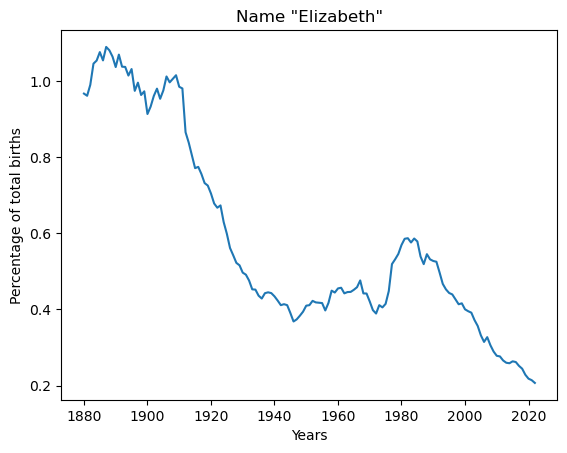

In [633]:
chosen_name = 'Elizabeth'

percentage_df = baby_name_df.loc[chosen_name]['percentage'].to_frame().reset_index()
percentage_df.sort_values(by=['year'], ascending=True, inplace=True)
print(f"There are {len(percentage_df)} years with a character named {chosen_name}. \nThe earliest year is {percentage_df['year'].min()} and the latest is {percentage_df['year'].max()}.")

x_values = percentage_df['year'].values
y_values = percentage_df['percentage'].values

# Plotting
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Name "{chosen_name}"')

In [634]:
# filter the name_by_movie and keep only name_by_movie where the movie have the most ratings in the release year and remove all the other nam_by_movie released that year.
# for each name divide the years into three dataframes, one for significant increase, one for significant decrease, and one one without significance. Rank these dataframes based on the t-statistic modulusne for no change (use p-value and t-statistic. Then get the top five of the three dataframes for each name.